# Домашняя работа 2

## Регрессия

С 1-ого октября отменяется НДС на бриллианты, теперь они становятся новым инвестиционным инструментом. Давайте сделаем модель ценообразования для них.

Скачайте датасет diamonds.csv

В нем представлены характеристики бриллиантов и их цены с сайта jamesallen (B2C площадка) с 2022-07-01

**Описание полей**


* fluor - флуорисценция (свойство камня светиться в ультрафиолетовых лучах)
* symmetry - показатель симметричности
* platform - название платформы, где был размещен камень
* quality_group - составной показатель из cut polish symmetry
* size_group - каратно весовая группа
* big_size_group - каратно-весовая группа
* shape - форма
* color - цвет
* clarity - чистота
* cut - качество огранки (может быть только у круглых камней)
* polish - полировка
* id - номер камня
* date - дата
* price - цена
* carat - кол-во карат
* tablepercent - размер площадки по отношению ширине
* price_per_carat - цена за карат
* z - длина (diameter)
* x - ширина
* depth_perc - отношение высоты к ширине
* y - высота



In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = 'drive/MyDrive/'

Mounted at /content/drive


In [3]:
df = pd.read_csv(path + '/Classroom/DS 16 IV/diamonds.csv', index_col=0)

In [4]:
df.head(10)

,fluor,symmetry,platform,shape,color,clarity,cut,polish,id,date,price,carat,price_per_carat,z,x,depth_perc,y
135269,NONE,EX,jamesallen,PS,F,SI1,NaN,EX,13870838,202206,12850.0,1.55,8290.32,10.29,6.41,62.0,3.97420
48477,MED,EX,jamesallen,RD,H,VVS2,EX,EX,11725253,202207,7510.0,1.02,7362.75,6.41,6.45,62.5,4.03125
236786,NONE,EX,jamesallen,EM,H,IF,NaN,EX,14444347,202205,21220.0,2.01,10557.21,8.60,6.37,65.0,4.14050
235781,NONE,EX,jamesallen,RD,E,VS2,EX,EX,14438434,202207,8660.0,1.00,8660.00,6.39,6.44,61.4,3.95416
277744,NONE,VG,jamesallen,RD,F,VS1,VG,EX,14615276,202206,8480.0,1.00,8480.00,6.28,6.36,62.3,3.96228
143407,FNT,EX,jamesallen,RD,J,VVS1,EX,EX,13945129,202205,12120.0,1.50,8080.00,7.38,7.41,60.0,4.44600
189202,NONE,EX,jamesallen,PS,D,SI2,NaN,EX,14224443,202205,9120.0,1.51,6039.74,10.67,6.23,59.0,3.67570
76462,NONE,VG,jamesallen,EM,K,SI2,NaN,VG,12902293,202205,1390.0,0.91,1527.47,6.30,4.58,71.0,3.25180
10333,NONE,VG,jamesallen,RD,D,VS2,EX,VG,4666424,202207,19150.0,1.51,12682.12,7.31,7.27,62.4,4.53648
72397,NONE,VG,jamesallen,PS,J,VS1,NaN,VG,12771762,202207,15990.0,2.27,7044.05,11.66,7.26,62.2,4.51572


Необходимо предсказать `price_per_carat`

### Задание 1: Очистка

Не все камни успевают продаться за один месяц, поэтому в таблице есть повторы. Объедините данные по одному камню: подумайте, как лучше это сделать, какую цену брать.

**Попробуйте найти аномалии:** вдруг цена на некоторые камни сильно меняется (то есть продавец сам не знает, по какой цене их продавать). Также убедитесь, что остальные параметры камня не меняются.

In [5]:
id_stat = df.groupby(by='id')['carat'].count().to_frame() #Посчитайте статистику по кол-ву камней

# разделите выборку на две части
one = id_stat.query("carat == 1").index.to_list()
three = id_stat.query("carat == 2 | carat == 3").index.to_list()
df_one = df.query(f'id in {one}')  # те камни, которые встречались один раз
df_three = df.query(f'id in {three}') # те камни, которые встречались 2 или 3 раза


stat = df_three.groupby('id')['price', 'carat', 'z', 'x', 'y', 'depth_perc'].agg(np.std) # Посчитайте стандартное отклонение по нескольким полям,
#  подумайте где оно должно равняться 0, а где меняться в каких-то разумных пределах
stat = stat.query("carat == 0 & x == 0 & z == 0 & y == 0 & depth_perc == 0")
stat = stat.query("price < 1000")

# Удалите аномальные наблюдения
df_three = df_three.query(f'id in {stat.index.to_list()}').sort_values(by=['id','date'])

df_three = df_three.groupby('id').agg('last').reset_index() #тепреь в качестве цены возьмем последнее значение по времени

df = pd.concat([df_one, df_three]).reset_index(drop=True) # соединяем результаты

<ipython-input-5-0380d90f4951>:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stat = df_three.groupby('id')['price', 'carat', 'z', 'x', 'y', 'depth_perc'].agg(np.std) # Посчитайте стандартное отклонение по нескольким полям,


Цены на бриллианты достаточно сильно меняются, попробуйте вычислить коэффициент инфляции и привести цены к последнему месяцу. Стоит учесть, что цены на все бриллианты не изменяются синхронно, то есть изменение в определенных группах может быть разным.

*Определите эти группы и рассчитайте коэффициенты инфляции для каждой из них. Подправьте цены на эти коэффициенты и создайте новую переменную.*

In [6]:
categories = ['carat', 'clarity', 'polish'] #определите по каким группам отпределять инфляцию (к примеру можно добавить каратную группу)

df_index = df.groupby(['date'] + categories)[['price_per_carat']]\
             .mean()\
             .reset_index() # индекс цен

date_max = df_index.date.max()


df_index = df_index.merge(df_index.query('date == @date_max')[categories + ['price_per_carat']]\
                          .rename(columns={'price_per_carat': 'price_per_carat_max'}), 
                          on=categories, how='outer') # сопоставляем группы с максимальной датой

df_index['inflation'] = df_index['price_per_carat_max'] / df_index.price_per_carat # вычисляем инфляцию

df_with_inf = df.merge(df_index[['date'] + categories + ['inflation']], 
                        on=['date'] + categories, how='left') # соединяем все в одной таблице
df_with_inf['inflation'] = df_with_inf['inflation'].fillna(1.0)
df_with_inf["price_with_inf"] = df_with_inf['price'] * df_with_inf['inflation']
df_with_inf

,fluor,symmetry,platform,shape,color,clarity,cut,polish,id,date,price,carat,price_per_carat,z,x,depth_perc,y,inflation,price_with_inf
0,NONE,EX,jamesallen,PS,D,SI2,NaN,EX,14224443,202205,9120.0,1.51,6039.74,10.67,6.23,59.0,3.67570,1.065339,9715.892605
1,NONE,VG,jamesallen,EM,K,SI2,NaN,VG,12902293,202205,1390.0,0.91,1527.47,6.30,4.58,71.0,3.25180,1.098470,1526.873715
2,NONE,VG,jamesallen,PS,J,VS1,NaN,VG,12771762,202207,15990.0,2.27,7044.05,11.66,7.26,62.2,4.51572,1.000000,15990.000000
3,MED,EX,jamesallen,RD,J,SI2,EX,EX,14584509,202205,3700.0,1.01,3663.37,6.37,6.42,62.0,3.98040,1.056196,3907.924691
4,NONE,EX,jamesallen,RD,G,SI1,EX,EX,14773748,202206,7170.0,1.00,7170.00,6.30,6.35,63.7,4.04495,1.030149,7386.171591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130879,NONE,EX,jamesallen,RD,I,SI1,EX,EX,15409696,202207,6040.0,1.01,5980.20,6.46,6.49,60.8,3.94592,1.000000,6040.000000
130880,MED,EX,jamesallen,OV,H,VVS2,None,EX,15410303,202207,6620.0,1.01,6554.46,7.76,5.40,65.0,3.51000,1.000000,6620.000000
130881,NONE,VG,jamesallen,EM,D,VS1,None,EX,15410668,202207,14750.0,1.50,9833.33,7.84,5.43,65.8,3.57294,1.000000,14750.000000
130882,MED,EX,jamesallen,EM,H,SI2,None,EX,15410717,202207,48230.0,4.53,10646.80,11.61,7.57,67.5,5.10975,1.000000,48230.000000


### Задание 2: Модель

Определите функцию потерь (MSE или MAE) и аргументируйте выбор.
Попробуйте сделать baseline.
Используйте LableEncoder для категориальных фичей и **постройте линейную модель**.

In [7]:
from sklearn.preprocessing import LabelEncoder
from typing import List

def encode(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
  for column in columns:
    le = LabelEncoder()
    values = le.fit_transform(df[column].unique())
    labels = le.classes_
    df[column].replace(dict(zip(labels, values)), inplace=True)
  return df

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error # Обладает лучшей интерпретируемостью
from sklearn.linear_model import LinearRegression


X = df.drop(columns=["id", "date", "price_per_carat", "depth_perc", "price", "platform"])
categorial = ["fluor", "symmetry", 'shape', 'color', 'clarity', 'cut', 'polish']
encode(X, categorial)
y = df["price_per_carat"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)

regression = LinearRegression()
regression.fit(X_train, y_train)
y_pred = regression.predict(X_valid)
print(f"MAE: {mean_absolute_error(y_valid, y_pred)}")

MAE: 1928.0486649626023


Теперь попробуйте OHE или TargetEncoder (сравните их).

Нормализуйте данные.

Поработайте с пропусками (обратите внимание на то, что у fluor возможен пропуск значения, а возможно отсутствие флуоресценции)

Покажите, насколько получилось улучшить результат.

In [9]:
! pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 4.5 MB/s eta 0:00:00


In [10]:
from sklearn.preprocessing import OneHotEncoder
from typing import Tuple

def OHE(df: pd.DataFrame, columns: List[str]) -> Tuple[pd.DataFrame, List[str]]:
    """
    Вместо это функции можно использовать и функционал pandas
    """
    index = df.index
    one = OneHotEncoder(sparse=False, categories='auto')
    ohe = one.fit_transform(df[columns])
    col_names = one.get_feature_names_out(input_features = columns)
    df = df.drop(columns, axis=1)
    df = df.reset_index(drop=True)
    df = pd.concat([df, pd.DataFrame(ohe, columns=col_names)], axis = 1)
    df = df.set_index(index)
    return (df, col_names)

In [11]:
from category_encoders import TargetEncoder

def TE(df: pd.DataFrame, columns: List[str], target: pd.Series) -> Tuple[pd.DataFrame, List[str]]:
  index = df.index
  te = TargetEncoder()
  values = te.fit_transform(df[columns], target)
  labels = te.get_feature_names_in()
  df = df.drop(columns, axis=1)
  df = df.reset_index(drop=True)
  df = pd.concat([df, pd.DataFrame(values, columns=labels)], axis=1)
  df = df.set_index(index)
  return (df, labels)

In [12]:
from sklearn.preprocessing import StandardScaler
from typing import Callable

categorial = ["fluor", "symmetry", 'shape', 'color', 'clarity', 'cut', 'polish']

def reg(df: pd.DataFrame, encoder: Callable, model = LinearRegression):
  X = df.drop(columns=["id", "date", "price_per_carat", "depth_perc", "price", "platform"])
  y = df["price_per_carat"]
  if encoder.__name__ == "OHE":
    X, _ = encoder(X, categorial)
  else:
    X, _ = encoder(X, categorial, y)

  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)
  
  scaler = StandardScaler() # Помните, что на тесте делаем только transform
  X_train = scaler.fit_transform(X_train)
  X_valid = scaler.transform(X_valid)

  m = model()
  m.fit(X_train, y_train)
  y_pred = m.predict(X_valid)

  print(f"encoder: {encoder.__name__}")
  print(f"MAE: {mean_absolute_error(y_valid, y_pred)}")
  return m

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130884 entries, 0 to 130883
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fluor            130880 non-null  object 
 1   symmetry         130884 non-null  object 
 2   platform         130884 non-null  object 
 3   shape            130884 non-null  object 
 4   color            130884 non-null  object 
 5   clarity          130884 non-null  object 
 6   cut              88698 non-null   object 
 7   polish           130884 non-null  object 
 8   id               130884 non-null  int64  
 9   date             130884 non-null  int64  
 10  price            130884 non-null  float64
 11  carat            130884 non-null  float64
 12  price_per_carat  130884 non-null  float64
 13  z                130884 non-null  float64
 14  x                130884 non-null  float64
 15  depth_perc       130884 non-null  float64
 16  y                130884 non-null  floa

In [14]:
df_dropped = df.dropna(subset="fluor").reset_index(drop=True)
reg(df_dropped, OHE)
reg(df_dropped, TE)
...

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


encoder: OHE
MAE: 1108.6370745206132
encoder: TE
MAE: 1171.8853979469184


Ellipsis

In [15]:
df_filled = df_dropped.fillna(value={"cut": 0}, axis=0)
reg(df_filled, TE)
#OHE и так выделяет nan в отдельную колонку
...

encoder: TE
MAE: 1171.8853979469184


Ellipsis

In [16]:
df_dropped_all = df_dropped.dropna().reset_index(drop=True)
reg(df_dropped_all, OHE)
reg(df_dropped_all, TE)
...

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


encoder: OHE
MAE: 1151.0187749825698
encoder: TE
MAE: 1221.5458892350277


Ellipsis

Сравните работу выбранной вами линейной модели с KNN

In [17]:
from sklearn.neighbors import KNeighborsRegressor

reg(df_dropped, OHE, KNeighborsRegressor)
reg(df_dropped, TE, KNeighborsRegressor)
reg(df_dropped_all, OHE, KNeighborsRegressor)
reg(df_dropped_all, TE, KNeighborsRegressor)
...

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


encoder: OHE
MAE: 806.7462618429095
encoder: TE
MAE: 630.7297363997554


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


encoder: OHE
MAE: 684.7479259301015
encoder: TE
MAE: 603.893498196167


Ellipsis

Метод ближайших соседей оказался эффективнее выбранной линейной модели. 

При чём для линейной модели эффективнее оказался метод кодирования OHE, а для kNN - TargetEncoder. Связано это, скорее всего, с тем, что OHE увеличивает размерность пространства признаков

Стоит также отметить, что эффективность линейной модели упала при удалении достаточно большого количества пропусков, эффективность же kNN при этом возросла

## Классификация

Загрузите датасет bodyPerformance

Описание:

https://www.kaggle.com/datasets/kukuroo3/body-performance-data

In [18]:
from google.colab import drive
drive.mount('/content/drive')

path = 'drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
df = pd.read_csv(path + '/Classroom/DS 16 IV/bodyPerformance.csv') #укажите свой путь

In [20]:
df

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...
13388,25.0,M,172.1,71.80,16.2,74.0,141.0,35.8,17.4,47.0,198.0,C
13389,21.0,M,179.7,63.90,12.1,74.0,128.0,33.0,1.1,48.0,167.0,D
13390,39.0,M,177.2,80.50,20.1,78.0,132.0,63.5,16.4,45.0,229.0,A
13391,64.0,F,146.1,57.70,40.4,68.0,121.0,19.3,9.2,0.0,75.0,D


### Задание 1: Определение гендера

Постройте модель, которая будет определять гендер.

Для этого определите две метрики качества, на которые вы будете смотреть. Аргументируйте свой выбор.

После чего преобразуйте категориальные переменные и постройте модель бинарной классификации на основе линейного классификатора и сравните с KNN.

P.S.: не забудте про нормализацию.

In [21]:
genders = df["gender"].value_counts()
print(genders[0]/genders[1])
genders

1.718838814453918


M    8467
F    4926
Name: gender, dtype: int64

Одного класса практически в два раза больше

In [22]:
dict_gender = {"M": 1, "F": 0}
dict_class = {"A": 3, "B": 2, "C": 1, "D": 0}

df['gender'] = df['gender'].replace(dict_gender)
df['class'] = df['class'].replace(dict_class)
df

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,1,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,1
1,25.0,1,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,3
2,31.0,1,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,1
3,32.0,1,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,2
4,28.0,1,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
13388,25.0,1,172.1,71.80,16.2,74.0,141.0,35.8,17.4,47.0,198.0,1
13389,21.0,1,179.7,63.90,12.1,74.0,128.0,33.0,1.1,48.0,167.0,0
13390,39.0,1,177.2,80.50,20.1,78.0,132.0,63.5,16.4,45.0,229.0,3
13391,64.0,0,146.1,57.70,40.4,68.0,121.0,19.3,9.2,0.0,75.0,0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  int64  
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 1.2 MB


In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
# f1score будет одновременно учитывать и Presicion, и Recall
# roc_auc будет устойчив к несбалансированным классам

X = df.drop(columns=["gender", "class"])
y = df["gender"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)

scaler = StandardScaler()
scaler.fit(X_train, y_train)

X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_valid = pd.DataFrame(scaler.transform(X_valid), index=X_valid.index, columns=X_valid.columns)

In [25]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_test_lr = lr.predict(X_valid)
y_proba_test_lr = lr.predict_proba(X_valid)[:, 1]
y_pred_train_lr = lr.predict(X_train)
y_proba_train_lr = lr.predict_proba(X_train)[:, 1]

In [26]:
kNN = KNeighborsClassifier()
kNN.fit(X_train, y_train)

y_pred_test_knn = kNN.predict(X_valid)
y_proba_test_knn = kNN.predict_proba(X_valid)[:, 1]
y_pred_train_knn = kNN.predict(X_train)
y_proba_train_knn = kNN.predict_proba(X_train)[:, 1]

Text(0.5, 43.7222222222222, 'Predicted value')

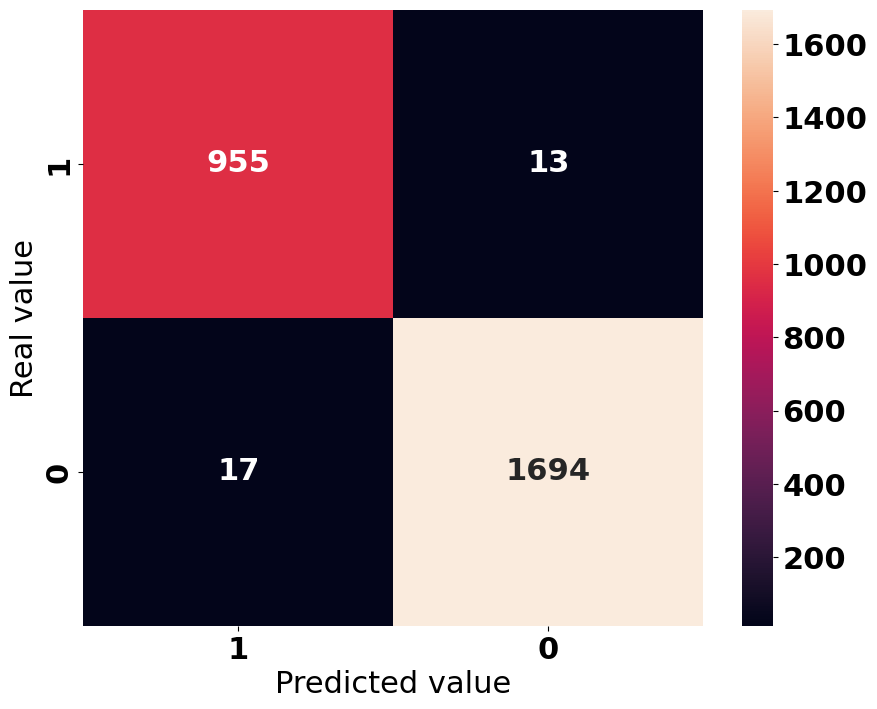

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
mp_mtx = confusion_matrix(y_valid, y_pred_test_lr)
font = {'family': "DejaVu Sans", 'weight': 'bold', 'size': 22}
plt.rc('font', **font)
fig = plt.figure(figsize=(10,8))
sns.heatmap(mp_mtx, annot=True, fmt="d", 
            xticklabels=df["gender"].unique(), 
            yticklabels=df["gender"].unique())
plt.ylabel("Real value")
plt.xlabel("Predicted value")

In [29]:
print("f1-score:")
print("LR:")
print(f"TEST - {f1_score(y_valid, y_pred_test_lr)}")
print(f"TRAIN - {f1_score(y_train, y_pred_train_lr)}")
print("kNN:")
print(f"TEST - {f1_score(y_valid, y_pred_test_knn)}")
print(f"TRAIN - {f1_score(y_train, y_pred_train_knn)}")

f1-score:
LR:
TEST - 0.9912229373902868
TRAIN - 0.9878554502369669
kNN:
TEST - 0.9909436167104879
TRAIN - 0.9905086756636512


In [30]:
print("ROC-AUC:")
print("LR:")
print(f"TEST - {roc_auc_score(y_valid, y_proba_test_lr)}")
print(f"TRAIN - {roc_auc_score(y_train, y_proba_train_lr)}")
print("kNN:")
print(f"TEST - {roc_auc_score(y_valid, y_proba_test_knn)}")
print(f"TRAIN - {roc_auc_score(y_train, y_proba_train_knn)}")

ROC-AUC:
LR:
TEST - 0.9969376566794343
TRAIN - 0.9977520028984025
kNN:
TEST - 0.9940884456917081
TRAIN - 0.9994603453191608


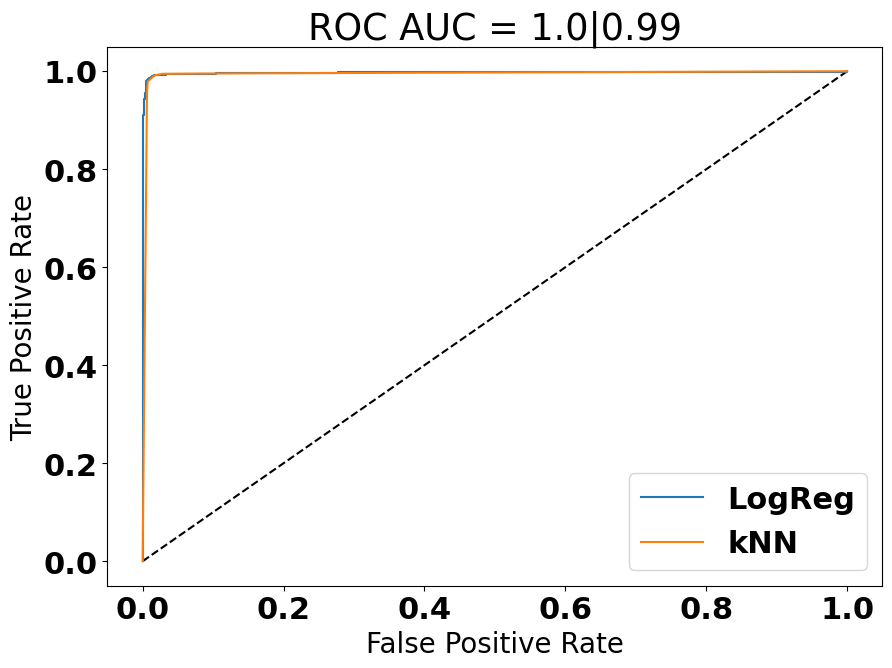

In [31]:
from sklearn.metrics import roc_curve, auc

fpr_lr, tpr_lr, _ = roc_curve(y_valid, y_proba_test_lr)
fpr_knn, tpr_knn, _ = roc_curve(y_valid, y_proba_test_knn)

plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label="LogReg")
plt.plot(fpr_knn, tpr_knn, label="kNN")
plt.title(f'ROC AUC = {round(auc(fpr_lr, tpr_lr),2)}|{round(auc(fpr_knn, tpr_knn), 2)}')
plt.ylabel("True Positive Rate", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=20)
plt.legend()
plt.show()

На тестовой выборке линейная модель оказалась чуточку лучше, а на тренировочной - чуточку хуже. В любом случае, модели получились хорошими, практически идеальными, что даже несколько удивительно

### Задание 2: Определение класса

Теперь опробуем построить модель, которая будет предсказывать class физической формы.

Для этого определите метрики качества для задачи мультиклассификации (аргументируйте выбор).

Постройте модель мультиклассовой классификации на основе линейного классификатора и сравните с KNN.

В качестве метрик качества были выбраны accuracy и ROC-AUC. Accuracy был выбран так как классы сбалансированы. ROC-AUC была выбрана из-за высокой устойчивости и хорошей интерпретируемости

In [32]:
df['class'].value_counts()

1    3349
0    3349
3    3348
2    3347
Name: class, dtype: int64

In [33]:
X = df.drop(columns=["gender", "class"])
y = df["class"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)

scaler = StandardScaler()
scaler.fit(X_train, y_train)

X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_valid = pd.DataFrame(scaler.transform(X_valid), index=X_valid.index, columns=X_valid.columns)

In [34]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_test_lr = lr.predict(X_valid)
y_proba_test_lr = lr.predict_proba(X_valid)
y_pred_train_lr = lr.predict(X_train)
y_proba_train_lr = lr.predict_proba(X_train)

In [35]:
kNN = KNeighborsClassifier()
kNN.fit(X_train, y_train)

y_pred_test_knn = kNN.predict(X_valid)
y_proba_test_knn = kNN.predict_proba(X_valid)
y_pred_train_knn = kNN.predict(X_train)
y_proba_train_knn = kNN.predict_proba(X_train)

Text(0.5, 43.7222222222222, 'Predicted value')

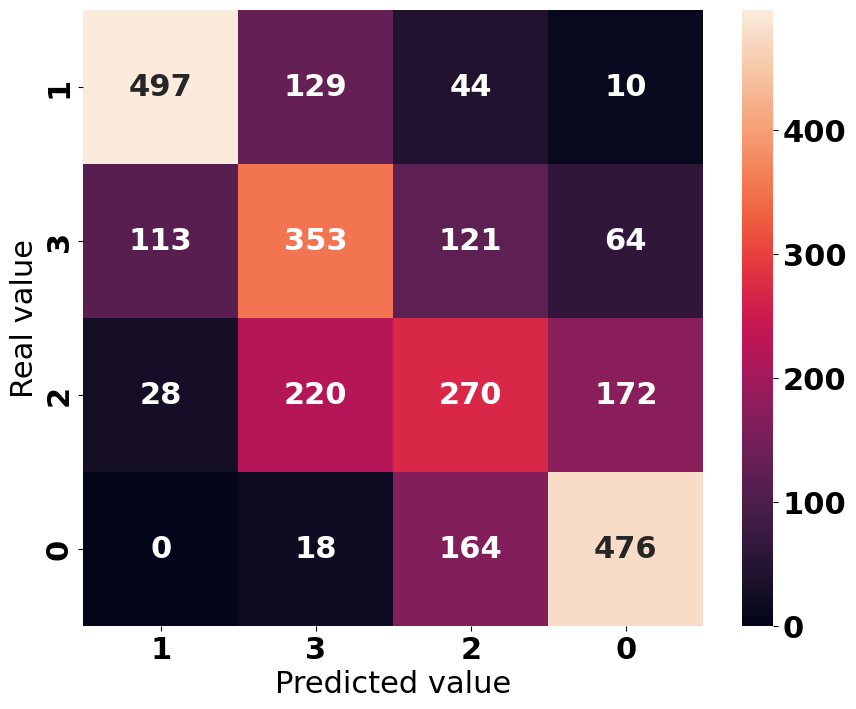

In [36]:
mp_mtx = confusion_matrix(y_valid, y_pred_test_lr)
font = {'family': "DejaVu Sans", 'weight': 'bold', 'size': 22}
plt.rc('font', **font)
fig = plt.figure(figsize=(10,8))
sns.heatmap(mp_mtx, annot=True, fmt="d", 
            xticklabels=df["class"].unique(), 
            yticklabels=df["class"].unique())
plt.ylabel("Real value")
plt.xlabel("Predicted value")

In [37]:
from sklearn.metrics import accuracy_score

print("Accuracy:")
print("LR:")
print(f"TEST - {accuracy_score(y_valid, y_pred_test_lr)}")
print(f"TRAIN - {accuracy_score(y_train, y_pred_train_lr)}")
print("kNN:")
print(f"TEST - {accuracy_score(y_valid, y_pred_test_knn)}")
print(f"TRAIN - {accuracy_score(y_train, y_pred_train_knn)}")

Accuracy:
LR:
TEST - 0.5957446808510638
TRAIN - 0.6103229419451185
kNN:
TEST - 0.5931317655841732
TRAIN - 0.741833115549748


In [38]:
print("ROC-AUC (ovr):")
print("LR:")
print(f"TEST - {roc_auc_score(y_valid, y_proba_test_lr, multi_class='ovr')}")
print(f"TRAIN - {roc_auc_score(y_train, y_proba_train_lr, multi_class='ovr')}")
print("kNN:")
print(f"TEST - {roc_auc_score(y_valid, y_proba_test_knn, multi_class='ovr')}")
print(f"TRAIN - {roc_auc_score(y_train, y_proba_train_knn, multi_class='ovr')}")

ROC-AUC (ovr):
LR:
TEST - 0.8424906426061602
TRAIN - 0.8452810119654051
kNN:
TEST - 0.816896377832811
TRAIN - 0.9263163422350883


Линейная модель оказалась незначительно лучше kNN на тестовой выборке и сильно хуже на тренировочной. Линейная модель получилась неплохой, если судить по ROC-AUC, но глядя на accuracy, можно сказать, что ей ещё есть куда расти.

In [39]:
from sklearn.decomposition import PCA

pca= PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.9) + 1
print('Количество признаков, описывающих 90% дисперсии =', dim)

Количество признаков, описывающих 90% дисперсии = 6


In [40]:
pca = PCA(n_components=6)
X_train = pca.fit_transform(X_train)
X_valid = pca.transform(X_valid)

In [41]:
lr.fit(X_train, y_train)

y_pred_test_lr = lr.predict(X_valid)
y_proba_test_lr = lr.predict_proba(X_valid)
y_pred_train_lr = lr.predict(X_train)
y_proba_train_lr = lr.predict_proba(X_train)

In [42]:
kNN.fit(X_train, y_train)

y_pred_test_knn = kNN.predict(X_valid)
y_proba_test_knn = kNN.predict_proba(X_valid)
y_pred_train_knn = kNN.predict(X_train)
y_proba_train_knn = kNN.predict_proba(X_train)

In [43]:
print("Accuracy:")
print("LR:")
print(f"TEST - {accuracy_score(y_valid, y_pred_test_lr)}")
print(f"TRAIN - {accuracy_score(y_train, y_pred_train_lr)}")
print("kNN:")
print(f"TEST - {accuracy_score(y_valid, y_pred_test_knn)}")
print(f"TRAIN - {accuracy_score(y_train, y_pred_train_knn)}")

Accuracy:
LR:
TEST - 0.574468085106383
TRAIN - 0.5822288594362516
kNN:
TEST - 0.5640164240388205
TRAIN - 0.718592495799888


In [44]:
print("ROC-AUC (ovr):")
print("LR:")
print(f"TEST - {roc_auc_score(y_valid, y_proba_test_lr, multi_class='ovr')}")
print(f"TRAIN - {roc_auc_score(y_train, y_proba_train_lr, multi_class='ovr')}")
print("kNN:")
print(f"TEST - {roc_auc_score(y_valid, y_proba_test_knn, multi_class='ovr')}")
print(f"TRAIN - {roc_auc_score(y_train, y_proba_train_knn, multi_class='ovr')}")

ROC-AUC (ovr):
LR:
TEST - 0.8238874011611341
TRAIN - 0.828365181754273
kNN:
TEST - 0.7951029246466674
TRAIN - 0.9201411748846131


При уменьшении количества признаков, результаты стали хуже